In [1]:
#Prediction of Temperature and Salinity profiles for an example section Example_input.nc
#date : February 2022
#author : Loic Bachelot (loic.bachelot@gmail.com) & Etienne Pauthenet (etienne.pauthenet@gmail.com)
import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from joblib import load
from keras import backend as K
import xarray as xr
import numpy as np
import pandas as pd
import time
from pathlib import Path
import gsw
import glob
import matplotlib.pyplot as plt
from numba import float64, guvectorize
import cmocean


path_ds = 'Example_input.nc'
path_models = 'models_Gulf_Stream'


In [2]:
def get_mean_std_pred(ensemble, X, ds, Sm, Sstd, Tm, Tstd):
    predS = []
    predT = []
    mld = []
    for model in ensemble:
        tmp_pred = model.predict(X)
        temp = tmp_pred[:, :, 1] * Tstd + Tm
        psal = tmp_pred[:, :, 0] * Sstd + Sm
        predS.append(psal)
        predT.append(temp)
        mld.append(tmp_pred[:, :, 2])
    return np.mean(predS, axis=0), np.std(predS, axis=0), np.mean(predT, axis=0), np.std(predT, axis=0), np.mean(mld, axis=0)

def get_MLD_from_mask(mask):
    depth_levels = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 19, 22, 26, 30, 35, 40, 45, 50, 55,
                    60, 65, 70, 75, 80, 90, 100, 110, 120, 133, 147, 163, 180, 199, 221, 245, 271,
                    301, 334, 371, 412, 458, 509, 565, 628, 697, 773, 857, 950, 1000]
    mask = np.sign(0.5 - mask)
    return depth_levels[np.argmin(mask)]

def add_sig(ds):
    SA = gsw.SA_from_SP(ds['psal'], ds['PRES_INTERPOLATED'], ds['lon'], ds['lat'])
    CT = gsw.CT_from_t(SA, ds['temp'], ds['PRES_INTERPOLATED'])
    sig = gsw.sigma0(SA, CT)
    ds = ds.assign(variables={"sig": (('lat', 'PRES_INTERPOLATED'), sig.data)})
    return ds

def predict(x, ensemble, scal_Sm, scal_Sstd, scal_Tm, scal_Tstd, scaler_input, suffix):
    # ----------- create X vector --------------- #
    d = 1/365
    cos_week = np.cos(np.pi * 2 * d * x['dayOfYear'].data)
    sin_week = np.sin(np.pi * 2 * d * x['dayOfYear'].data)
    X = np.zeros([len(x['lat']), 12])
    X[:,0] = x['SLA'].data
    X[:,1] = x['lat'].data
    X[:,2] = x['lon'].data
    X[:,3] = cos_week
    X[:,4] = sin_week
    X[:,5] = x['MDT'].data
    X[:,6] = x['UGOSA'].data
    X[:,7] = x['VGOSA'].data
    X[:,8] = x['UGOS'].data
    X[:,9] = x['VGOS'].data
    X[:,10] = x['SST'].data
    X[:,11] = -x['BATHY'].data

    X_scaled = scaler_input.transform(X)

    # ------------- Predict and add to dataset -------------- #
    get_MLD_from_mask_vect = np.vectorize(get_MLD_from_mask, signature='(k)->()')
    pred_S_mean, pred_S_std, pred_T_mean, pred_T_std, mld = get_mean_std_pred(ensemble, X_scaled, x, scal_Sm, scal_Sstd, scal_Tm, scal_Tstd)
    x = x.assign(variables={"psal": (('lat', 'PRES_INTERPOLATED'), pred_S_mean.data)})
    x = x.assign(variables={"temp": (('lat', 'PRES_INTERPOLATED'), pred_T_mean.data)})
    x = x.assign(variables={"MLD_mask": (('lat', 'PRES_INTERPOLATED'), mld.data)})
    x = x.assign(variables={"mld": (('lat'), get_MLD_from_mask_vect(x.MLD_mask))})
    x = x.assign(variables={"psal_std": (('lat', 'PRES_INTERPOLATED'), pred_S_std.data)})
    x = x.assign(variables={"temp_std": (('lat', 'PRES_INTERPOLATED'), pred_T_std.data)})
    x = add_sig(x)
    
    x.to_netcdf(f"Prediction{suffix}.nc")
    print(f"size output file: {np.around(x.nbytes / 1073741824,2)} Go, saved in Prediction{suffix}.nc")

In [3]:
#Load scalers
scaler_input = load(f"{path_models}/scaler_input.joblib")
scal_Sm = load(f'{path_models}/Sm.joblib')
scal_Sstd = load(f'{path_models}/Sstd.joblib')
scal_Tm = load(f'{path_models}/Tm.joblib')
scal_Tstd = load(f'{path_models}/Tstd.joblib')

/Users/gmaze/anaconda/envs/OSnet/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
%%time
#Load models
models_list = glob.glob(f'{path_models}/neuralnet/ensemble/*')
ensemble = []
for model_path in models_list:
    ensemble.append(keras.models.load_model(model_path, compile=False))

2022-02-14 14:35:22.407655: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 4.74 s, sys: 159 ms, total: 4.9 s
Wall time: 5.02 s


In [10]:
#Load input data
x = xr.open_dataset('Example_input.nc')
x

<xarray.Dataset>
Dimensions:            (lat: 108, PRES_INTERPOLATED: 51)
Coordinates:
  * lat                (lat) float32 23.12 23.38 23.62 ... 49.38 49.62 49.88
    lon                float32 ...
    time               datetime64[ns] ...
    mask               (lat) float64 ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
Data variables:
    SLA                (lat) float32 ...
    MDT                (lat) float32 ...
    BATHY              (lat) float32 ...
    UGOS               (lat) float32 ...
    VGOS               (lat) float32 ...
    UGOSA              (lat) float32 ...
    VGOSA              (lat) float32 ...
    SST                (lat) float32 ...
    dayOfYear          int32 ...

In [6]:
#Run prediction
time_start = time.time()
print(f'Starting prediction for a section')
predict(x=x, ensemble=ensemble, scal_Sm=scal_Sm, scal_Sstd=scal_Sstd, scal_Tm=scal_Tm,
                          scal_Tstd=scal_Tstd, scaler_input=scaler_input, suffix="_TS")
print(f"Computation finished in {np.around(time.time() - time_start,2)} secondes")

Starting prediction for a section
size output file: 0.0 Go, saved in Prediction_TS.nc
Computation finished in 1.46 secondes


In [ ]:
x

In [7]:
def add_maskv3(ds):
    b = 2
    b2 = 1
    H = 0.5664     #For OSnet Gulf Stream    
    mask2 = np.where(ds['MLD_mask'].data<H, ds['MLD_mask'], 1)
    ds = ds.assign(variables={"MLD_mask2": (('lat', 'PRES_INTERPOLATED'), mask2)})
    mask3 = np.where((ds['MLD_mask']>H) & (ds['MLD_mask']<b2), b-ds['MLD_mask'].data, ds['MLD_mask2'].data)
    ds = ds.assign(variables={"MLD_mask3": (('lat', 'PRES_INTERPOLATED'), mask3)})
    return ds


@guvectorize(
    "(float64[:], float64[:], float64[:], float64[:], float64[:], float64[:])",
    "(n), (n), (n), (n) -> (n), (n)"
)
def apply_mask_1d(temp_in, psal_in, depth, mask, temp, psal):
    temp[:] = np.copy(temp_in)
    psal[:] = np.copy(psal_in)
    for d in range(len(depth)-2, -1, -1):
        # apply mask on TEMP and PSAL
        temp[d] = (temp_in[d]*mask[d] - temp_in[d+1]*mask[d]) + temp[d+1]
        psal[d] = (psal_in[d]*mask[d] - psal_in[d+1]*mask[d]) + psal[d+1]

def post_processing_adjustment(ds,mask):
    temp_out, psal_out = xr.apply_ufunc(apply_mask_1d,
                                    ds['temp'], ds['psal'], ds['PRES_INTERPOLATED'], mask,
                                    input_core_dims=(['PRES_INTERPOLATED'],['PRES_INTERPOLATED'],['PRES_INTERPOLATED'],['PRES_INTERPOLATED']),
                                    output_core_dims=(['PRES_INTERPOLATED'],['PRES_INTERPOLATED']),
                                    output_dtypes=[np.float64, np.float64])
    # get sig adjusted
    sa_out = gsw.SA_from_SP(psal_out, ds['PRES_INTERPOLATED'], ds['lon'], ds['lat'])
    ct_out = gsw.CT_from_t(sa_out,temp_out,ds['PRES_INTERPOLATED'])
    sig_out = gsw.sigma0(sa_out, ct_out)
    
    ds_out = ds.assign(variables={"temp_adj": (('lat','PRES_INTERPOLATED'), temp_out.data),
                                  "psal_adj": (('lat','PRES_INTERPOLATED'), psal_out.data),
                                  "sig_adj": (('lat','PRES_INTERPOLATED'), sig_out.data)})
    return ds_out 

In [8]:
#Run MLD adjustment
ds = xr.open_dataset("Prediction_TS.nc")
ds = add_maskv3(ds)
ds = post_processing_adjustment(ds, mask = ds['MLD_mask3'])
ds.to_netcdf("Prediction_TS_adj.nc")
print(f"size output file: {np.around(ds.nbytes / 1073741824,2)} Go, saved in Prediction_TS_adj.nc")
ds

size output file: 0.0 Go, saved in Prediction_TS_adj.nc


<xarray.Dataset>
Dimensions:            (lat: 108, PRES_INTERPOLATED: 51)
Coordinates:
  * lat                (lat) float32 23.12 23.38 23.62 ... 49.38 49.62 49.88
    lon                float32 ...
    time               datetime64[ns] ...
    mask               (lat) float64 ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
Data variables: (12/21)
    SLA                (lat) float32 ...
    MDT                (lat) float32 ...
    BATHY              (lat) float32 ...
    UGOS               (lat) float32 ...
    VGOS               (lat) float32 ...
    UGOSA              (lat) float32 ...
    ...                 ...
    sig                (lat, PRES_INTERPOLATED) float64 ...
    MLD_mask2          (lat, PRES_INTERPOLATED) float32 4.178e-05 ... 1.0
    MLD_mask3          (lat, PRES_INTERPOLATED) float32 4.178e-05 ... 1.0
    temp_adj           (lat, PRES_INTERPOLATED) float64 29.26 29.26 ... nan nan
    psal_adj           (lat, PRES_INTERPOLATED) float64 36.61 36.61 ... nan nan
    sig_adj            (lat, PRES_INTERPOLATED) float64 23.19 23.19 ... nan nan

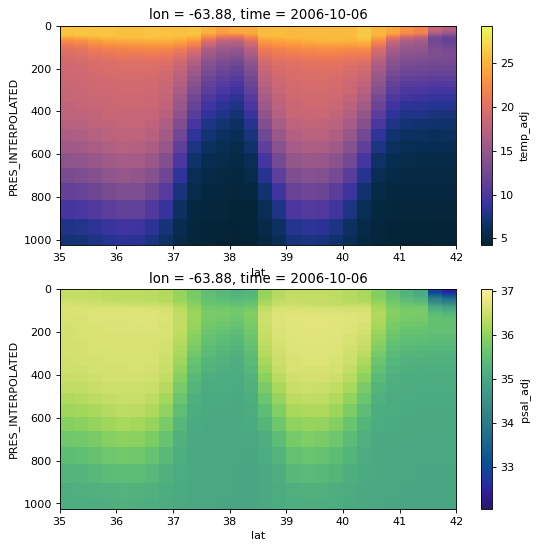

In [9]:
#Data visualisation
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

ds.temp_adj.T.plot(ax = ax[0],yincrease = False, cmap = cmocean.cm.thermal)
ds.psal_adj.T.plot(ax = ax[1],yincrease = False, cmap = cmocean.cm.haline)
for i in np.arange(2):
    ax[i].set_xlim([35,42])
